In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from dyck_k_generator import constants

In [3]:
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'mps'

In [4]:
if device == "mps":
    torch.mps.empty_cache()
elif device == "cuda:0":
    torch.cuda.empty_cache()

In [5]:
torch.manual_seed(42)

In [6]:
k = 1

In [7]:
from dyck_k_generator.generator import generate_dataset

path = generate_dataset(
    n=1000,
    k=k,
    max_length=10,
    balanced=0.55,
)

Generating unbalanced strings: 100%|██████████| 450/450 [00:00<00:00, 65302.45it/s]
Saving dataset to data/dyck-1_1000-samples_10-len_p055.jsonl: 100%|██████████| 1000/1000 [00:00<00:00, 660936.65it/s]

Dataset saved to data/dyck-1_1000-samples_10-len_p055.jsonl


In [8]:
VOCAB = "".join(
    ["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]]
)
VOCAB

'()'

In [9]:
from dataset.dataset import DyckLanguageDataset

In [10]:
dataset = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 1000 samples from data/dyck-1_1000-samples_10-len_p055.jsonl


Tokenizing strings: 100%|██████████| 1000/1000 [00:00<00:00, 455358.16it/s]


In [11]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = int(0.15 * train_size)
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

In [12]:
from torch.utils.data import DataLoader

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Manual Transformer + BERTViz


In [14]:
from transformer.hooked_transformer import (
    TransformerClassifier,
    TransformerClassifierConfig,
    causal_mask,
    pad_token_mask,
)

In [15]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=256,
    n_heads=1,
    dim_ff=384,
    n_layers=1,
    n_classes=2,
    max_seq_len=10,
)

In [17]:
model_bidirectional = TransformerClassifier(model_config)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /Users/matiasmolinolo/.netrc


In [18]:
model_bidirectional.to(device)

TransformerClassifier(
  (embedding): Embedding(5, 256)
  (pos_encoder): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (attn): MultiHeadAttention(
          (q_linear): Linear(in_features=256, out_features=256, bias=True)
          (k_linear): Linear(in_features=256, out_features=256, bias=True)
          (v_linear): Linear(in_features=256, out_features=256, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (residual_dropout): Dropout(p=0.1, inplace=False)
          (attn): ScaledDotProductAttention()
          (out): Linear(in_features=256, out_features=256, bias=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=256, out_features=384, bias=True)
          (1): Dropout(p=0.1, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=384, out_features=256, bias=True)
        )
        (ln1): La

In [19]:
import torch.optim as optim

crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_bidirectional.parameters(), lr=1e-4)

In [20]:
train_loss, train_acc, val_loss, val_acc = model_bidirectional.train_model(
    device=device,
    epochs=20,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0785 | Train Acc: 52.50%
Val Loss: 1.3787 | Val Acc: 53.33%
Epoch 2/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0722 | Train Acc: 53.37%
Val Loss: 1.3875 | Val Acc: 46.67%
Epoch 3/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.2181 | Train Acc: 52.75%
Val Loss: 1.3645 | Val Acc: 53.33%
Epoch 4/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 7.8127 | Train Acc: 67.75%
Val Loss: 0.8792 | Val Acc: 100.00%
Epoch 5/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 4.2025 | Train Acc: 96.75%
Val Loss: 0.2597 | Val Acc: 100.00%
Epoch 6/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 1.3417 | Train Acc: 99.38%
Val Loss: 0.0488 | Val Acc: 100.00%
Epoch 7/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.3402 | Train Acc: 99.88%
Val Loss: 0.0130 | Val Acc: 100.00%
Epoch 8/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.1365 | Train Acc: 100.00%
Val Loss: 0.0061 | Val Acc: 100.00%
Epoch 9/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0624 | Train Acc: 100.00%
Val Loss: 0.0032 | Val Acc: 100.00%
Epoch 10/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0602 | Train Acc: 99.88%
Val Loss: 0.0030 | Val Acc: 100.00%
Epoch 11/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0552 | Train Acc: 99.88%
Val Loss: 0.0020 | Val Acc: 100.00%
Epoch 12/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0230 | Train Acc: 100.00%
Val Loss: 0.0011 | Val Acc: 100.00%
Epoch 13/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0195 | Train Acc: 100.00%
Val Loss: 0.0008 | Val Acc: 100.00%
Epoch 14/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0201 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 15/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0265 | Train Acc: 100.00%
Val Loss: 0.0010 | Val Acc: 100.00%
Epoch 16/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0121 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%
Epoch 17/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0104 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 18/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0092 | Train Acc: 100.00%
Val Loss: 0.0004 | Val Acc: 100.00%
Epoch 19/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0063 | Train Acc: 100.00%
Val Loss: 0.0003 | Val Acc: 100.00%
Epoch 20/20


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 0.0158 | Train Acc: 100.00%
Val Loss: 0.0002 | Val Acc: 100.00%


In [21]:
test_loss, test_acc = model_bidirectional.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.0013 | Test Acc: 100.00%


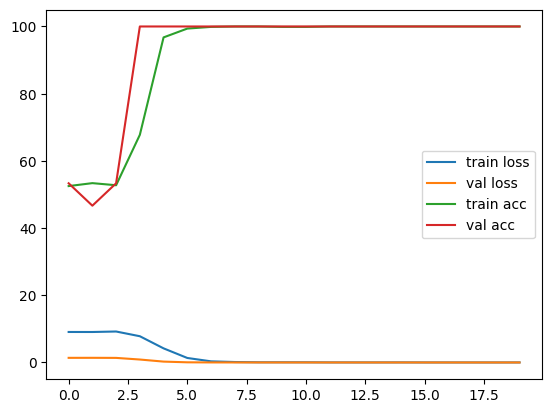

In [22]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label="train loss")
plt.plot(val_loss, label="val loss")
plt.plot(train_acc, label="train acc")
plt.plot(val_acc, label="val acc")
plt.legend()
plt.show()

In [23]:
model_causal = TransformerClassifier(model_config).to(device)

train_acc,▁▁▁▂▁▂▂▃▇▇██████████████████████████████
train_loss,███▇███▆▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▁▁▂███████████████████████████████████
val_loss,█████▅▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,100.0
train_loss,0.00047
val_acc,100.0
val_loss,0.00013


In [24]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model_causal.parameters(), lr=1e-4)

In [25]:
train_loss, train_acc, val_loss, val_acc = model_causal.train_model(
    device=device,
    epochs=50,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="causal",
)

Epoch 1/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0708 | Train Acc: 53.12%
Val Loss: 1.3824 | Val Acc: 53.33%
Epoch 2/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0601 | Train Acc: 53.75%
Val Loss: 1.3809 | Val Acc: 53.33%
Epoch 3/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1170 | Train Acc: 49.38%
Val Loss: 1.3839 | Val Acc: 53.33%
Epoch 4/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1658 | Train Acc: 52.00%
Val Loss: 1.3841 | Val Acc: 53.33%
Epoch 5/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0932 | Train Acc: 51.50%
Val Loss: 1.3981 | Val Acc: 53.33%
Epoch 6/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0258 | Train Acc: 55.75%
Val Loss: 1.3975 | Val Acc: 46.67%
Epoch 7/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1602 | Train Acc: 51.75%
Val Loss: 1.3831 | Val Acc: 53.33%
Epoch 8/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0574 | Train Acc: 52.12%
Val Loss: 1.3898 | Val Acc: 53.33%
Epoch 9/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0446 | Train Acc: 53.25%
Val Loss: 1.3883 | Val Acc: 46.67%
Epoch 10/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1281 | Train Acc: 50.00%
Val Loss: 1.3895 | Val Acc: 53.33%
Epoch 11/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0929 | Train Acc: 50.50%
Val Loss: 1.3894 | Val Acc: 53.33%
Epoch 12/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0457 | Train Acc: 53.00%
Val Loss: 1.3843 | Val Acc: 53.33%
Epoch 13/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0882 | Train Acc: 52.75%
Val Loss: 1.3818 | Val Acc: 53.33%
Epoch 14/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0569 | Train Acc: 52.50%
Val Loss: 1.3821 | Val Acc: 53.33%
Epoch 15/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1559 | Train Acc: 49.75%
Val Loss: 1.4089 | Val Acc: 53.33%
Epoch 16/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1169 | Train Acc: 51.62%
Val Loss: 1.3842 | Val Acc: 53.33%
Epoch 17/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9474 | Train Acc: 54.12%
Val Loss: 1.3813 | Val Acc: 53.33%
Epoch 18/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9681 | Train Acc: 53.00%
Val Loss: 1.4010 | Val Acc: 53.33%
Epoch 19/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1492 | Train Acc: 53.00%
Val Loss: 1.3949 | Val Acc: 46.67%
Epoch 20/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0900 | Train Acc: 54.12%
Val Loss: 1.3971 | Val Acc: 53.33%
Epoch 21/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1294 | Train Acc: 49.75%
Val Loss: 1.3932 | Val Acc: 53.33%
Epoch 22/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9554 | Train Acc: 55.38%
Val Loss: 1.3831 | Val Acc: 53.33%
Epoch 23/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1191 | Train Acc: 47.88%
Val Loss: 1.3861 | Val Acc: 53.33%
Epoch 24/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9657 | Train Acc: 54.50%
Val Loss: 1.3890 | Val Acc: 53.33%
Epoch 25/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0336 | Train Acc: 55.25%
Val Loss: 1.3813 | Val Acc: 53.33%
Epoch 26/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1578 | Train Acc: 48.25%
Val Loss: 1.4224 | Val Acc: 53.33%
Epoch 27/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0209 | Train Acc: 54.87%
Val Loss: 1.3835 | Val Acc: 53.33%
Epoch 28/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0231 | Train Acc: 53.25%
Val Loss: 1.3912 | Val Acc: 53.33%
Epoch 29/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0245 | Train Acc: 54.75%
Val Loss: 1.3821 | Val Acc: 53.33%
Epoch 30/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1230 | Train Acc: 47.62%
Val Loss: 1.3934 | Val Acc: 53.33%
Epoch 31/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0101 | Train Acc: 53.87%
Val Loss: 1.3836 | Val Acc: 53.33%
Epoch 32/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0187 | Train Acc: 53.50%
Val Loss: 1.3884 | Val Acc: 53.33%
Epoch 33/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0016 | Train Acc: 54.12%
Val Loss: 1.3818 | Val Acc: 53.33%
Epoch 34/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0824 | Train Acc: 51.75%
Val Loss: 1.3975 | Val Acc: 53.33%
Epoch 35/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1101 | Train Acc: 55.12%
Val Loss: 1.3827 | Val Acc: 53.33%
Epoch 36/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9954 | Train Acc: 50.88%
Val Loss: 1.3873 | Val Acc: 53.33%
Epoch 37/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.1155 | Train Acc: 53.25%
Val Loss: 1.3824 | Val Acc: 53.33%
Epoch 38/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0703 | Train Acc: 54.12%
Val Loss: 1.3845 | Val Acc: 53.33%
Epoch 39/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9857 | Train Acc: 52.00%
Val Loss: 1.3820 | Val Acc: 53.33%
Epoch 40/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 9.0224 | Train Acc: 53.62%
Val Loss: 1.3891 | Val Acc: 53.33%
Epoch 41/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9606 | Train Acc: 55.88%
Val Loss: 1.3824 | Val Acc: 53.33%
Epoch 42/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9826 | Train Acc: 55.25%
Val Loss: 1.3861 | Val Acc: 53.33%
Epoch 43/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9879 | Train Acc: 53.37%
Val Loss: 1.3870 | Val Acc: 53.33%
Epoch 44/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9919 | Train Acc: 53.87%
Val Loss: 1.3839 | Val Acc: 53.33%
Epoch 45/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9965 | Train Acc: 54.25%
Val Loss: 1.3812 | Val Acc: 53.33%
Epoch 46/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9909 | Train Acc: 52.12%
Val Loss: 1.3845 | Val Acc: 53.33%
Epoch 47/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9642 | Train Acc: 55.62%
Val Loss: 1.3827 | Val Acc: 53.33%
Epoch 48/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.8938 | Train Acc: 55.88%
Val Loss: 1.3914 | Val Acc: 53.33%
Epoch 49/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9875 | Train Acc: 54.50%
Val Loss: 1.3826 | Val Acc: 53.33%
Epoch 50/50


  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Train Loss: 8.9996 | Train Acc: 55.25%
Val Loss: 1.3816 | Val Acc: 53.33%


In [26]:
test_loss, test_acc = model_causal.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="causal",
)

  0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 6.8053 | Test Acc: 60.00%


# Attention plots:


In [40]:
batch = next(iter(test_dataloader))
strings, labels, tokens = batch

mask = causal_mask(tokens)
attn_matrices = model_bidirectional.get_attn_matrices(tokens, mask)

In [41]:
from transformer_viz.visualizer import min_max_normalize, plot_attn_matrices

In [42]:
from dataset.dataset import DyckLanguageTokenizer

In [43]:
batch = (
    ")))))))(((((((",
    True,
    DyckLanguageTokenizer(VOCAB).tokenize(")))))))(((((((").to(device),
)
batch

Tokenizing strings: 100%|██████████| 1/1 [00:00<00:00, 10866.07it/s]


(')))))))(((((((',
 True,
 tensor([[0., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 2.]],
        device='mps:0'))

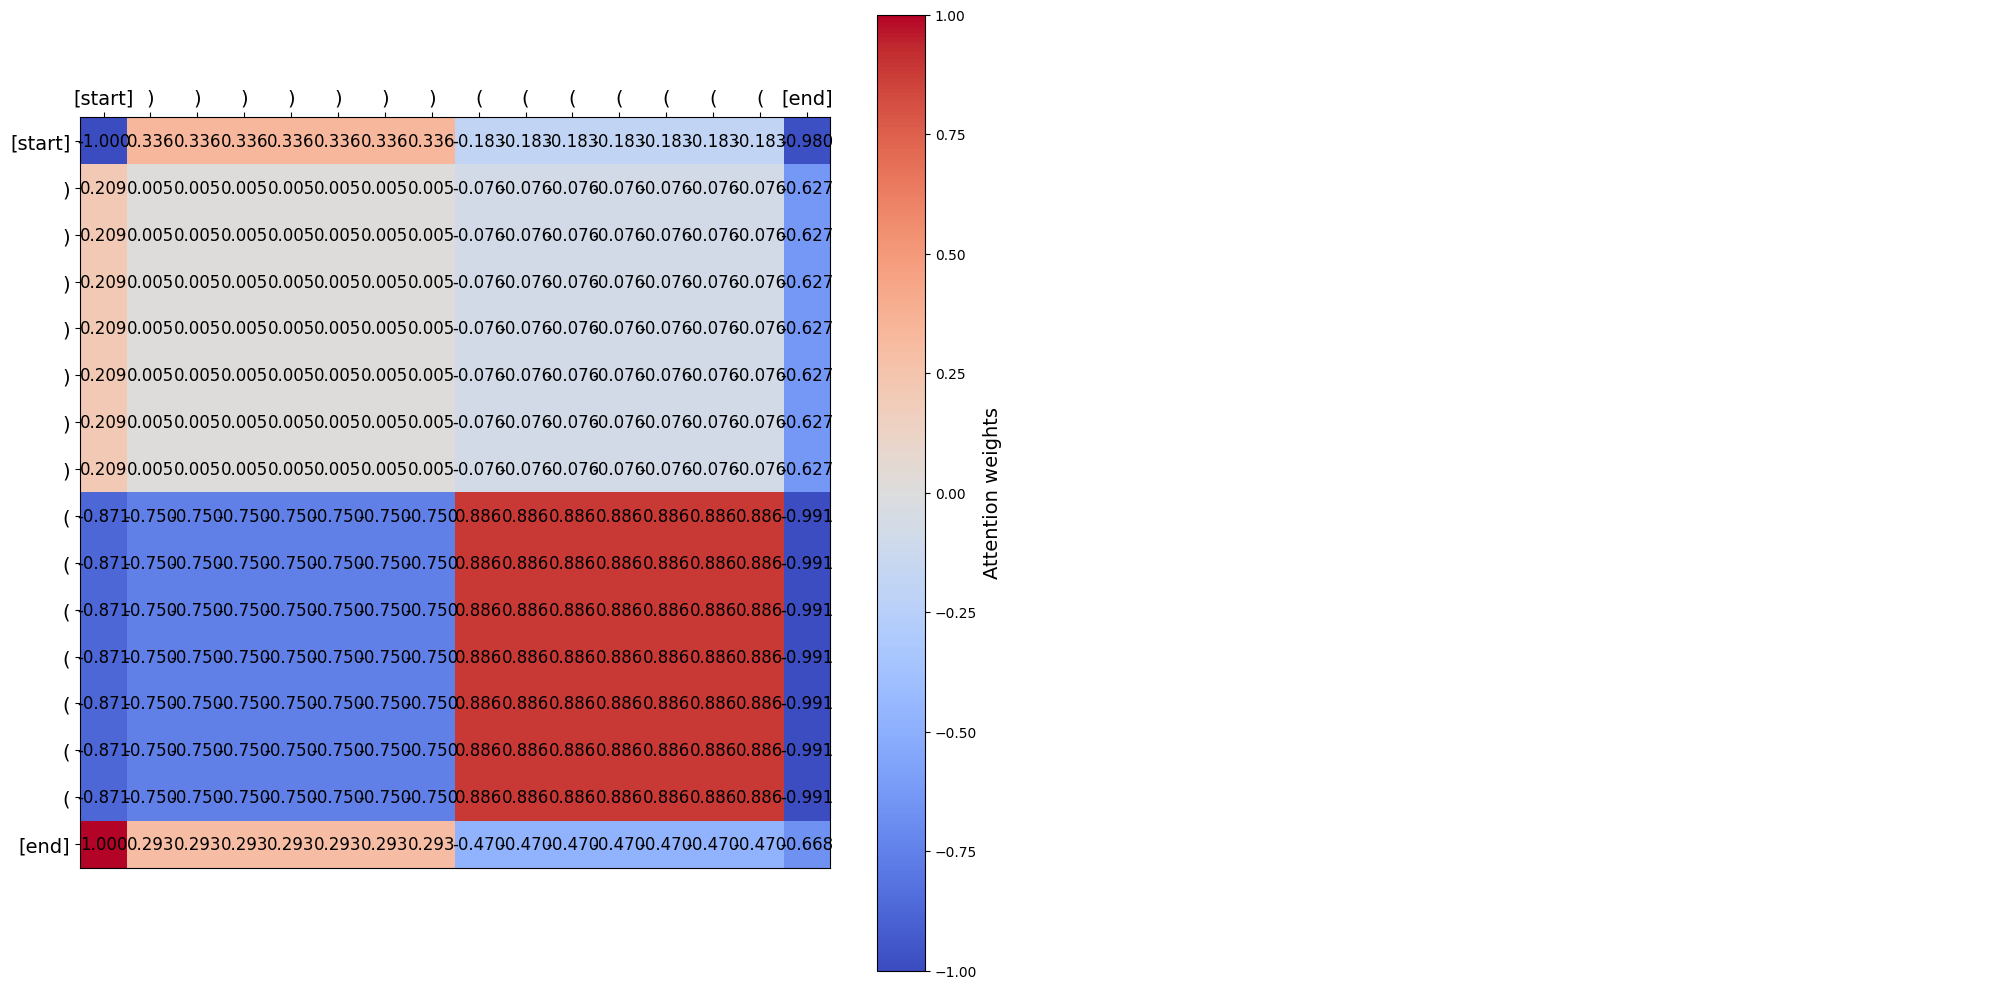

In [44]:
plot_attn_matrices(VOCAB, batch, model_bidirectional, min_max_normalize, pad_token_mask)

In [45]:
minimax_norm = min_max_normalize(attn_matrices[0][0][0].cpu().detach().numpy())

In [46]:
minimax_norm[0][0]

1.0

# Experiment 2

We will experiment with the same grammar, using a causal mask instead of a bidirectional one.


In [ ]:
model_two = TransformerClassifier(model_config).to(device)

# Experiment 3

Dyck-3


In [27]:
k = 3

In [28]:
path = generate_dataset(
    n=5_000,
    k=3,
    min_length=8,
    max_length=8,
    balanced=0.6,
)

Generating unbalanced strings: 100%|██████████| 2000/2000 [00:00<00:00, 26041.31it/s]
Saving dataset to data/dyck-3_5000-samples_8-len_p06.jsonl: 100%|██████████| 5000/5000 [00:00<00:00, 719508.70it/s]


Dataset saved to data/dyck-3_5000-samples_8-len_p06.jsonl


In [29]:
VOCAB = "".join(
    ["".join((key, value)) for key, value in list(constants.BRACKETS.items())[:k]]
)
VOCAB

'()[]{}'

In [30]:
dataset_dyck_2 = DyckLanguageDataset(path, VOCAB).to(device)

Loaded 5000 samples from data/dyck-3_5000-samples_8-len_p06.jsonl


Tokenizing strings: 100%|██████████| 5000/5000 [00:00<00:00, 703411.82it/s]


In [31]:
train_size = int(0.8 * len(dataset_dyck_2))
val_size = int(0.15 * train_size)
test_size = len(dataset_dyck_2) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset_dyck_2, [train_size, val_size, test_size]
)

In [32]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [57]:
model_config = TransformerClassifierConfig(
    vocab_size=len(VOCAB),
    d_model=512,
    n_heads=1,
    dim_ff=1024,
    n_layers=1,
    n_classes=2,
    max_seq_len=10,
)

In [58]:
model = TransformerClassifier(model_config).to(device)

train_acc,▁▄▅█████████████████████████████████████
train_loss,█▄▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▅▆▁▃▁▂██████████████████████████████████
val_loss,█▃▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,100.0
train_loss,0.00021
val_acc,100.0
val_loss,0.00014


In [59]:
crit = torch.nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [60]:
train_loss, train_acc, val_loss, val_acc = model.train_model(
    device=device,
    epochs=15,
    optimizer=optimizer,
    criterion=crit,
    train_dataloader=train_dataloader,
    eval_dataloader=val_dataloader,
    use_mask="bidirectional",
)

Epoch 1/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 23.0380 | Train Acc: 84.60%
Val Loss: 1.0200 | Val Acc: 99.00%
Epoch 2/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 3.8476 | Train Acc: 99.17%
Val Loss: 0.3884 | Val Acc: 99.00%
Epoch 3/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 1.9387 | Train Acc: 99.17%
Val Loss: 0.2194 | Val Acc: 99.00%
Epoch 4/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.9763 | Train Acc: 99.38%
Val Loss: 0.0820 | Val Acc: 100.00%
Epoch 5/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.3685 | Train Acc: 99.98%
Val Loss: 0.0228 | Val Acc: 100.00%
Epoch 6/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.1623 | Train Acc: 100.00%
Val Loss: 0.0123 | Val Acc: 100.00%
Epoch 7/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0916 | Train Acc: 100.00%
Val Loss: 0.0072 | Val Acc: 100.00%
Epoch 8/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0590 | Train Acc: 100.00%
Val Loss: 0.0041 | Val Acc: 100.00%
Epoch 9/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0408 | Train Acc: 100.00%
Val Loss: 0.0030 | Val Acc: 100.00%
Epoch 10/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0300 | Train Acc: 100.00%
Val Loss: 0.0021 | Val Acc: 100.00%
Epoch 11/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0218 | Train Acc: 100.00%
Val Loss: 0.0018 | Val Acc: 100.00%
Epoch 12/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0174 | Train Acc: 100.00%
Val Loss: 0.0012 | Val Acc: 100.00%
Epoch 13/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0133 | Train Acc: 100.00%
Val Loss: 0.0010 | Val Acc: 100.00%
Epoch 14/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0106 | Train Acc: 100.00%
Val Loss: 0.0008 | Val Acc: 100.00%
Epoch 15/15


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Loss: 0.0099 | Train Acc: 100.00%
Val Loss: 0.0007 | Val Acc: 100.00%


In [61]:
test_loss, test_acc = model.eval_model(
    device=device,
    test_dataloader=test_dataloader,
    criterion=crit,
    use_mask="bidirectional",
)

  0%|          | 0/50 [00:00<?, ?it/s]

Test Loss: 0.0024 | Test Acc: 100.00%


In [62]:
batch = next(iter(test_dataloader))
batch

[('}((}[)))',
  '[][[]][]',
  '()(){{}}',
  '[]((()))',
  '}((}[)))',
  '[][][[]]',
  '[{{}}()]',
  '()[(())]'),
 tensor([0., 1., 1., 1., 0., 1., 1., 1.], device='mps:0'),
 tensor([[0., 8., 3., 3., 8., 5., 4., 4., 4., 2.],
         [0., 5., 6., 5., 5., 6., 6., 5., 6., 2.],
         [0., 3., 4., 3., 4., 7., 7., 8., 8., 2.],
         [0., 5., 6., 3., 3., 3., 4., 4., 4., 2.],
         [0., 8., 3., 3., 8., 5., 4., 4., 4., 2.],
         [0., 5., 6., 5., 6., 5., 5., 6., 6., 2.],
         [0., 5., 7., 7., 8., 8., 3., 4., 6., 2.],
         [0., 3., 4., 5., 3., 3., 4., 4., 6., 2.]], device='mps:0')]

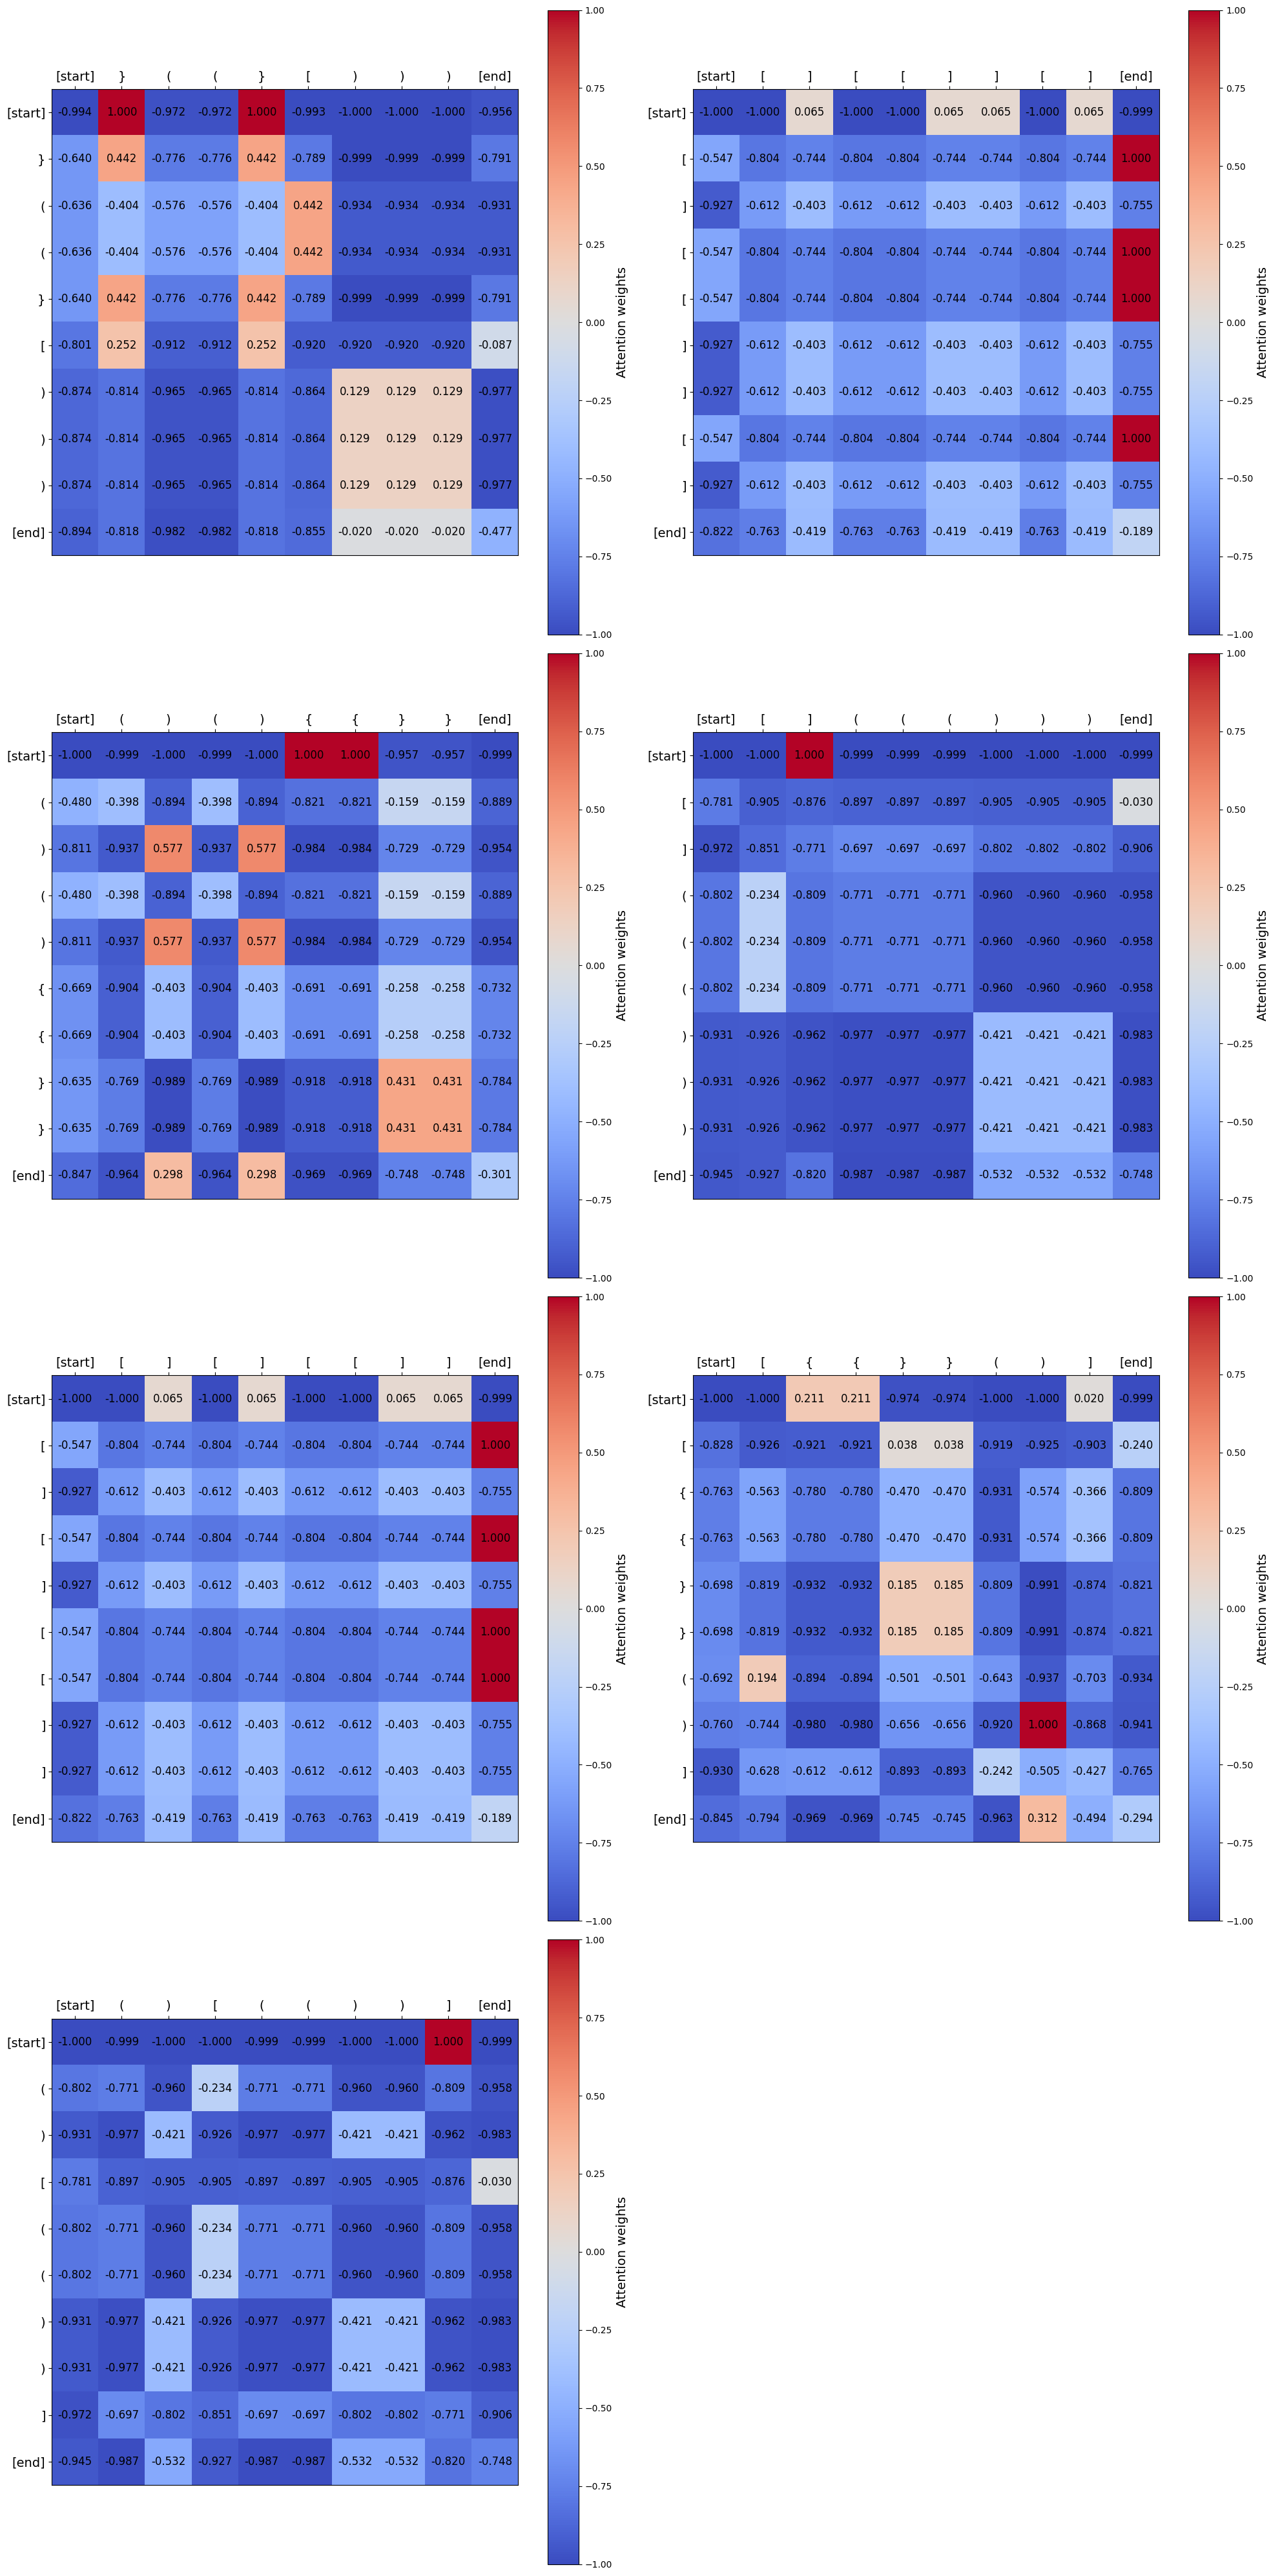

In [63]:
plot_attn_matrices(VOCAB, batch, model, min_max_normalize, pad_token_mask)